In [2]:
"%%capture"
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

**Modèle entrainement RNN**

Dans ce notebook, nous allons utiliser plusieurs modèles d'apprentissage différents. Il sera donc facile de les comparer et d'évaluer leur performance.

### Plan du Notebook
- Description des fonctions utilitaires
- Modèle 1 : Backpropagation sur l'ensemble des valeurs prédites
- Modèle 2 : Truncated Backpropagation through time
- Modèle 3 : activité neuronale prédite au temps $t+1$ trouvée par l'activité neuronale théorique au temps $t$
- Évaluation de la performance de CURBD
- Extra : Évaluation modèle utilisant LBFGS



---

La fonction *rnn* prend en entré les conditions initiales, le temps, $\mu$ et les conditions initiales. À partir de ces valeurs, il construit la séquence de pas de temps. Utiliser le format suivant :

<code> train = rnn(t=np.linspace(), x=data["Data"].T, W=W)[0]<code>

In [3]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, W, dydx=dydx, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    """Approximate RNN behaviors using RK4 numerical method

    Args:
        t (ndarray): Time array (np.linspace)
        IC (ndarray): Line vector -> Initial condition
        W (ndarray): Weight matrix of shape (n_neuron x n_neuron)
        dydx (function, optional): Differential equation. Defaults to dydx.
        sigma (Function, optional): Activation function. Defaults to lambdax:((1+np.exp(-x))**(-1)).
        mu (float, optional): Activation threshold. Defaults to 0.

    Returns:
        ndarray: Activity at each time step
        float : dt
    """

    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

La fonction *GenerateData* prend en entrée le nombre de valeur total, le temps total, les conditions initials, $\mu$ et la matrice de poid. On l'appel ainsi :

<code> 
IC = np.random.rand(n_neuron)

W = np.random.randn(n_neuron, n_neuron)

data = GenerateData(n_data=2000, time=20, IC=IC, W=W)

In [4]:
def GenerateData(n_data, time, IC, W, ratio=1, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    """Generate fake data that follow a RNN function

    Args:
        n_data (int): Number of data per neuron
        time (float): Time of our sample
        IC (ndarray): Initials conditions
        W (ndarray): Weight matrix (n_neuron x n_neuron)
        ratio (float, optional): Ratio of our data that will be use for training. Defaults to 1.
        mu (float, optional): Activation threshold. Defaults to 0.
        sigma (function, optional): Non-linearities. Defaults to lambdax:(1+np.exp(-x))**(-1).

    Returns:
        dict: Parameter of the data
    """

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

La fonction *quality* évalue la qualité du training de l'ensemble des neurones. Elle prend en entrée le nombre de neurone, les pas de temps théoriques et ceux entrainés. Elle affiche aussi les neuronnes les moins bien modélisées. On l'appel ainsi:

<code> 
true = rnn()[0]

train = rnn()[0] #Avec W = pred["W"]

quality(n_neuron=n_neuron, true=true, train=train)

In [5]:
def quality(n_neuron, true, train, num_max=1):
    """Plot and identify the quality of the training

    Args:
        n_neuron (int): Number of neuron in our system
        true (ndarray): True model
        train (ndarray): Train model
        num_max (int, optional): Number of neurons with the worst loss function. Defaults to 1.

    Returns:
        list: list of worst neuron
    """
    
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst

Lors de nos entrainements, il est primordial de définir un module d'entrainement. La classe RNNModel permet de faire la discrétisation de Euler.

$\dot{\vec{x}} = -x+\sigma(Wx+\mu)$

Avec Euler :

$x(t+\Delta t) = x(t) + \Delta x =  x(t)[1-\Delta t]+\sigma(Wx-\mu)\Delta t$

In [38]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = nn.Parameter(W, requires_grad=True)
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

Dans tous ce notebook, deux métriques sont utilisés pour évaluer la qualité de l'entrainement. Tout d'abord, la fonction de perte *loss* est utilisée. Cette valeur est la *Mean square error* entre les valeurs théoriques et celle expérimentales. Toutefois, ce paramètre n'est pas suffisant. En effet, il est possible d'obtenir une perte relativement faible sans pour autant avoir obtenu un apprentissage. En fait, cela arrive losrque l'on tombe dans un minimum local. Ainsi, un deuxième métrique est utilisée, la proportion de variance (pVar) défini ainsi :

$\text{pVar} = 1 - \frac{\langle x_{\text{True}}(t)- x_{\text{Train}} (t)\rangle^2}{\langle x_{\text{True}}(t) - \bar{x}_{\text{True}}(t)\rangle^2} $

Ce métrique indique à quel point les valeurs prédites sont loins des valeurs théoriques. Si $\text{pVar} = 1$, c'est donc que nos valeur théoriques sont identiques à celle expérimentales. Il est possible d'obtenir une faible perte avec un mauvais $\text{pVar}$ dans les minimums locaux. Dans un monde idéal, nous obtenons ces valeurs :

- $\text{loss} = 0$
- $\text{pVar} = 1$

---

### Modèle 1
Ici, on débute par comparer l'ensemble des valeurs théoriques à celles prédites. La valeur théorique aux temps $x(t+1)$ est trouvée avec la valeur théorique au temps $x(t)$. Les valeurs au temps $x(t+2), x(t+N)$ sont trouvées à partir de la valeur expérimentale précédente. On appel cette fonction ainsi :

<code> pred = Train_RNN(n_neuron=n_neuron, x=data["Data"].T, dt=data["dt"], mu=data["mu"], lr=learning_rate, n_iters=max_epoch, g=1, momentum=0.5, verbose=True, loss_graph=True)

In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    """Function that train our RNN to match a specific model

    Args:
        n_neurons (int): Number of neuron
        x (ndarray): Matrix (n_data x n_neuron)
        dt (float): Euler's discretisation
        mu (flaot): Activation threshold
        lr (float, optional): Learning rate. Defaults to 1.
        n_iters (int, optional): Number of iterations (epoch). Defaults to 500.
        g (flaot, optional): Standard deviation of random matrix. Defaults to 1.
        momentum (float, optional): Momentum of SGD [0,1]. Defaults to 0.
        verbose (bool, optional): Update on epochs. Defaults to False.
        loss_graph (bool, optional): Plot loss graph. Defaults to False.

    Returns:
        dict: Parameters of the training
    """
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up

    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W, requires_grad=True)  #Parameter that will be modify

    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()


    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass

        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred[1] = model(x[0])  #Find x_pred at time (t+1)

        for i in range(x.shape[0] - 2):
            with torch.no_grad():
                x_pred_temp = x_pred[i+1].clone()
            x_pred[i+2] = model(x_pred_temp)

        #Loss
        l = loss(x, x_pred)   #We calculate x_pred than compute loss

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 1 == 0:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:   #Print loss graph
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

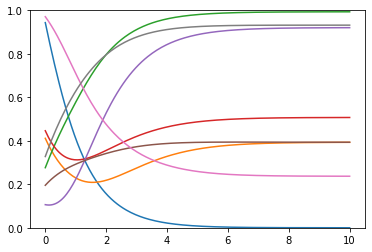

In [40]:
IC = np.random.rand(8)
W = 2*np.random.randn(8, 8)

data = GenerateData(200, 10, IC=IC, W=W)

t = np.linspace(0, 10, 200)

plt.plot(t, data["Data"].T)
plt.ylim([0,1])
plt.show()

epoch 0/70 loss 0.141326 pVar -22.077
epoch 1/70 loss 0.023546 pVar -0.695
epoch 2/70 loss 0.008622 pVar 0.506
epoch 3/70 loss 0.004239 pVar 0.747
epoch 4/70 loss 0.003812 pVar 0.770
epoch 5/70 loss 0.003545 pVar 0.786
epoch 6/70 loss 0.003355 pVar 0.801
epoch 7/70 loss 0.003158 pVar 0.814
epoch 8/70 loss 0.003011 pVar 0.827
epoch 9/70 loss 0.002861 pVar 0.835
epoch 10/70 loss 0.002743 pVar 0.846
epoch 11/70 loss 0.002630 pVar 0.852
epoch 12/70 loss 0.002549 pVar 0.861
epoch 13/70 loss 0.002478 pVar 0.863
epoch 14/70 loss 0.002454 pVar 0.870
epoch 15/70 loss 0.002431 pVar 0.868
epoch 16/70 loss 0.002497 pVar 0.871
epoch 17/70 loss 0.002499 pVar 0.866
epoch 18/70 loss 0.002686 pVar 0.865
epoch 19/70 loss 0.002634 pVar 0.861
epoch 20/70 loss 0.002924 pVar 0.856
epoch 21/70 loss 0.002713 pVar 0.859
epoch 22/70 loss 0.003021 pVar 0.855
epoch 23/70 loss 0.002643 pVar 0.865
epoch 24/70 loss 0.002881 pVar 0.863
epoch 25/70 loss 0.002443 pVar 0.878
epoch 26/70 loss 0.002576 pVar 0.879
epoch 27

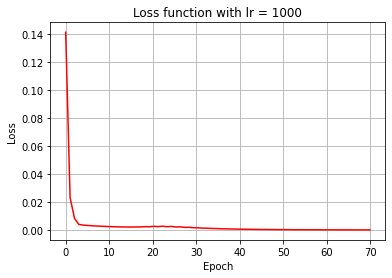

3.0972278118133545


In [41]:
start = time.time()
pred = Train_RNN(8, data["Data"].T, data["dt"], data["mu"], lr=1000, n_iters=70, g=1, momentum=0, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

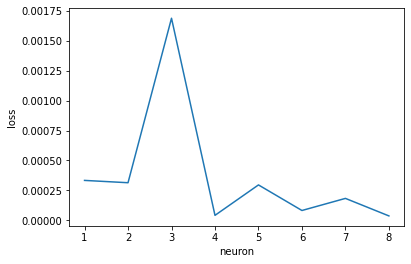

[2, 0, 1, 4, 6]

In [42]:
qual = quality(8, data["Data"].T, pred["x_pred"], num_max=5)
qual

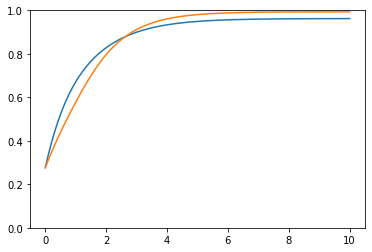

In [45]:
t = np.linspace(0, 10, 200)
plt.plot(t, pred["x_pred"][:,2], label="Train")
plt.plot(t, data["Data"].T[:,2], label="true")
plt.ylim([0,1])
plt.show()

Nous allons maintenant utiliser un modèle plus complexe de 172 neurones avec 4000 valeurs.

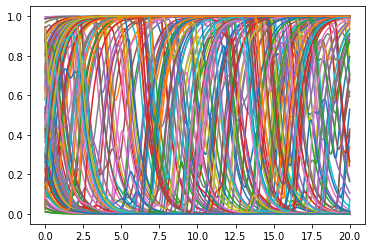

In [46]:
IC = np.random.rand(172)
W = 5*np.random.randn(172, 172)

data = GenerateData(3000, 30, IC=IC, W=W)
t = np.linspace(0, 20, 3000)

plt.plot(t, data["Data"].T)
plt.show()

epoch 0/40 loss 0.382328 pVar -24.570
epoch 1/40 loss 0.318013 pVar -26.140
epoch 2/40 loss 0.284857 pVar -17.651
epoch 3/40 loss 0.258973 pVar -30.497
epoch 4/40 loss 0.241597 pVar -29.289
epoch 5/40 loss 0.239303 pVar -29.010
epoch 6/40 loss 0.225115 pVar -28.179
epoch 7/40 loss 0.208889 pVar -25.067
epoch 8/40 loss 0.199562 pVar -24.212
epoch 9/40 loss 0.195630 pVar -25.488
epoch 10/40 loss 0.191852 pVar -23.047
epoch 11/40 loss 0.190724 pVar -21.419
epoch 12/40 loss 0.189504 pVar -22.023
epoch 13/40 loss 0.187941 pVar -21.145
epoch 14/40 loss 0.186719 pVar -22.233
epoch 15/40 loss 0.186693 pVar -21.941
epoch 16/40 loss 0.184697 pVar -21.499
epoch 17/40 loss 0.186278 pVar -20.926
epoch 18/40 loss 0.182398 pVar -21.524
epoch 19/40 loss 0.177848 pVar -21.156
epoch 20/40 loss 0.180715 pVar -23.016
epoch 21/40 loss 0.177803 pVar -22.582
epoch 22/40 loss 0.176390 pVar -21.112
epoch 23/40 loss 0.173164 pVar -20.113
epoch 24/40 loss 0.172458 pVar -21.304
epoch 25/40 loss 0.171430 pVar -20.

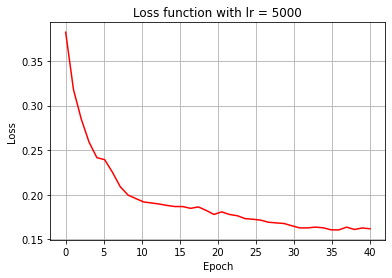

124.4237768650055


In [52]:
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], lr=5000, momentum=0.5, g=1, verbose=True, loss_graph=True, n_iters=40)
end = time.time()
print(end-start)

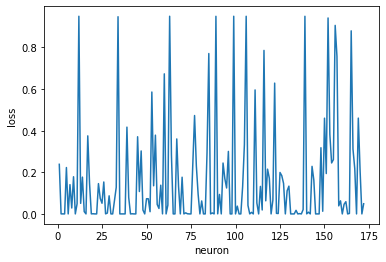

In [53]:
qual = quality(172, data["Data"].T, pred["x_pred"], 3)

On constate que le $\text{pVar}$ **diverge** lorsqu'on atteint des réseaux plus complexes.

### Modèle 2

Dans le deuxème modèle, nous explorons la *Truncated BackPropagation throught time* avec le cas spécifique $k_1 = k_2$. C'est donc dire que pour chaque $k_1$ pas de temps, on effectue une descente de gradient de $k_2$ pas de temps. Ici, nous définissons $K$ comme étant la valeur à laquelle nous divisons nos pas de temps. Par exemple, si nous avons 100 pas de temps avec $K=5$, alors nous séparons nos pas de temps en 5 paquets de 20.

On débute par entrainer un certains nombre de fois la première *batch* puisque celle-ci contient le plus d'information. On évite donc d'entrainer des neurones triviaux. Une fois que ceci est fait, on envoit notre nouvelle matrice **W** dans l'entrainement. Ainsi, l'objectif est d'obtenir une matrice plus près de la vraie réponse dans le vrai modèle. La première *batch* est entrainé <code> start </code> fois.



Malgré tout, on constate que :
- La matrice **W** change relativement peu
- L'apprentissage est donc minimale

In [400]:
def Train_RNN(n_neurons, x, dt, mu, K, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False, start=20):
    """Function that train our RNN to match a specific model

    Args:
        n_neurons (int): Number of neuron
        x (ndarray): Matrix (n_data x n_neuron)
        dt (float): Euler's discretisation
        mu (flaot): Activation threshold
        lr (float, optional): Learning rate. Defaults to 1.
        n_iters (int, optional): Number of iterations (epoch). Defaults to 500.
        g (float, optional): Standard deviation of random matrix. Defaults to 1.
        momentum (float, optional): Momentum of SGD [0,1]. Defaults to 0.
        verbose (bool, optional): Update on epochs. Defaults to False.
        loss_graph (bool, optional): Plot loss graph. Defaults to False.
        K (int) : number of batch

    Returns:
        dict: Parameters of the training
    """
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up

    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify

    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    previous = x[0]

    batch_size = int(x.shape[0] / K)

    start = start

    for epoch in range(start):

        x_pred = torch.zeros(batch_size, x.shape[1], dtype=torch.float32)
        x_pred[0] = previous
        for i in range(1, batch_size):
            with torch.no_grad():
                x_pred_temp = x_pred[i-1].clone()
                
            x_pred[i] = model(x_pred_temp)

            if i == (batch_size - 1):
                    
                l = loss(x_pred, x[0:batch_size])

                l.backward()

                optimizer.step()
                optimizer.zero_grad()


                if verbose :
                    with torch.no_grad():
                        y = x[0:batch_size].numpy()
                        y_pred = x_pred.numpy()
                        pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                        print(f"Start epoch {epoch}/{start} loss {l:.6f} pVar {pVar:.2f}")



    #Training
    for epoch in range(n_iters):

        for batch in range(x.shape[0] - batch_size):  #Number of time we have to change to the next time step

            x_pred = torch.zeros(batch_size, x.shape[1], dtype=torch.float32)
            x_pred[0] = previous


            for i in range(1, batch_size):
                with torch.no_grad():
                    x_pred_temp = x_pred[i-1].clone()

                x_pred[i] = model(x_pred_temp)

                if i == (batch_size - 1):  # We do the backpropagation

                    l = loss(x_pred, x[batch:batch+batch_size])

                    #Backpropagate
                    l.backward()

                    optimizer.step()
                    optimizer.zero_grad()

                        


                    previous = x[batch]

                        

                    if verbose :
                        with torch.no_grad():
                            y = x[batch:batch+batch_size].numpy()
                            y_pred = x_pred.numpy()
                            pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                            print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.2f}")


    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

C:\Users\Anthony\AppData\Local\Temp\ipykernel_21356\1389200343.py:1: RuntimeWarning: overflow encountered in exp
  def GenerateData(n_data, time, IC, W, ratio=1, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):


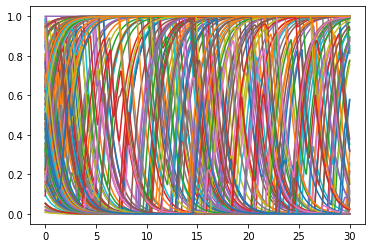

In [401]:
IC = np.random.rand(172)
W = 30*np.random.randn(172, 172)

data = GenerateData(2000, 30, IC=IC, W=W)
t = np.linspace(0, 30, 2000)

plt.plot(t, data["Data"].T)
plt.show()

In [402]:
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], lr=1000, momentum=0.2, g=1.3, verbose=True, loss_graph=False, n_iters=20, K=100, start=50)
end = time.time()
print(end-start)

Start epoch 0/50 loss 0.009908 pVar -5.62
Start epoch 1/50 loss 0.009782 pVar -5.57
Start epoch 2/50 loss 0.009628 pVar -5.50
Start epoch 3/50 loss 0.009465 pVar -5.42
Start epoch 4/50 loss 0.009299 pVar -5.33
Start epoch 5/50 loss 0.009132 pVar -5.24
Start epoch 6/50 loss 0.008964 pVar -5.14
Start epoch 7/50 loss 0.008797 pVar -5.04
Start epoch 8/50 loss 0.008634 pVar -4.94
Start epoch 9/50 loss 0.008475 pVar -4.84
Start epoch 10/50 loss 0.008323 pVar -4.74
Start epoch 11/50 loss 0.008179 pVar -4.65
Start epoch 12/50 loss 0.008044 pVar -4.55
Start epoch 13/50 loss 0.007918 pVar -4.45
Start epoch 14/50 loss 0.007801 pVar -4.36
Start epoch 15/50 loss 0.007691 pVar -4.28
Start epoch 16/50 loss 0.007589 pVar -4.20
Start epoch 17/50 loss 0.007492 pVar -4.12
Start epoch 18/50 loss 0.007399 pVar -4.05
Start epoch 19/50 loss 0.007310 pVar -3.98
Start epoch 20/50 loss 0.007226 pVar -3.92
Start epoch 21/50 loss 0.007146 pVar -3.85
Start epoch 22/50 loss 0.007070 pVar -3.80
Start epoch 23/50 los

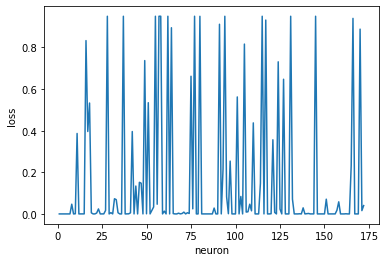

[56, 144, 114, 54, 57]

In [364]:
t = np.linspace(0,30,2000)
train = rnn(t, IC=IC, W=pred["W"])[0]
qual = quality(172, data["Data"].T, train, 5)
qual

In [365]:
print(pred["W"][2][0], pred["W0"][2][0])

0.6843198 0.73600423


### Modèle 3

Dans ce modèle, nous utilisons $x_{\text{True}}(t)$ pour trouver $x_{\text{Train}}(t+1)$. On obtient donc de faibles pertes. C'est le premier modèle exploré. Il est difficile d'obtenir de vraies valeurs avec cette méthode puisque la valeur prédite est toujours très près de la valeur théorique. On obtient donc une proportion de variance et une perte excellente à tout coup.

In [102]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=0.001, momentum=0.9, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = HessianFree(model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, dampening=0.5)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        x_pred[1:] = x_pred_temp.T

        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #if 4*epoch < n_iters:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=4*lr, momentum=0.8)

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

Les résultats :

epoch 0/5000 loss 0.000102 pVar 0.998
epoch 100/5000 loss 0.000042 pVar 0.999
epoch 200/5000 loss 0.000032 pVar 0.999
epoch 300/5000 loss 0.000025 pVar 0.999
epoch 400/5000 loss 0.000024 pVar 0.999
epoch 500/5000 loss 0.000023 pVar 0.999
epoch 600/5000 loss 0.000022 pVar 0.999
epoch 700/5000 loss 0.000021 pVar 1.000
epoch 800/5000 loss 0.000020 pVar 1.000
epoch 900/5000 loss 0.000020 pVar 1.000
epoch 1000/5000 loss 0.000019 pVar 1.000
epoch 1100/5000 loss 0.000019 pVar 1.000
epoch 1200/5000 loss 0.000019 pVar 1.000
epoch 1300/5000 loss 0.000019 pVar 1.000
epoch 1400/5000 loss 0.000019 pVar 1.000
epoch 1500/5000 loss 0.000019 pVar 1.000
epoch 1600/5000 loss 0.000019 pVar 1.000
epoch 1700/5000 loss 0.000018 pVar 1.000
epoch 1800/5000 loss 0.000018 pVar 1.000
epoch 1900/5000 loss 0.000017 pVar 1.000
epoch 2000/5000 loss 0.000017 pVar 1.000
epoch 2100/5000 loss 0.000017 pVar 1.000
epoch 2200/5000 loss 0.000017 pVar 1.000
epoch 2300/5000 loss 0.000017 pVar 1.000
epoch 2400/5000 loss 0.00001

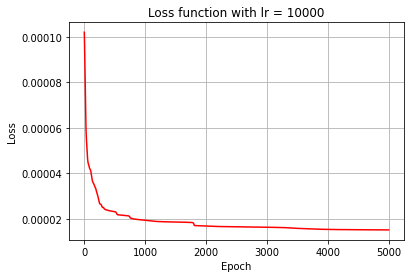

37.1370062828064


In [386]:
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], lr=10000, n_iters=5000, verbose=True, loss_graph=True, g=1, momentum=0.9)
end = time.time()
print(end-start)

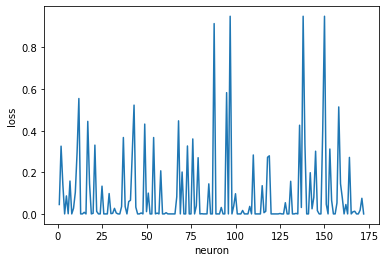

[149, 137, 96]

In [387]:
t = np.linspace(0, 30, 2000)
train = rnn(t=t, IC=IC, W=pred["W"])[0]

qual = quality(172, pred["x"], train, 3)
qual

### Évaluation de la qualité de CURBD
---

Ici, nous allons évaluer la qualité de la performance de CURBD. Nous allons utiliser le même exemple que dans le document *exampleFiringRate*. La fonction <code> quality </code> est utilisée pour évaluer la qualité des neuronnes.

*Remarque:*

In [105]:
import numpy as np
import pylab
import curbd
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

# Original data
#ts = loadmat('ts.mat')
#ts = ts['ts']
ts = np.load('1541_F_dff.npy')
ts = ts[:,0:4000]
print(len(ts))
# Smoothing and z-scoring 
sigma = 15
(N,T) = ts.shape
filtered_ts = np.zeros((N,T))
for i in range(N):
    new_ts = zscore(ts[i,:])
    #new_ts = new_ts-np.min(new_ts)
    new_ts = new_ts/np.max(np.abs(new_ts))
    new_ts = gaussian_filter1d(new_ts, sigma)
    filtered_ts[i,:]= new_ts

import time

t_init = time.time()

regions = []
regions.append(['Region A', np.arange(0, N)])
regions = np.array(regions, dtype=object)

model = curbd.trainMultiRegionRNN(filtered_ts,
                                  g=2,
                                  dtData=0.02,
                                  dtFactor=5,
                                  regions=regions,
                                  tauRNN=0.1,
                                  nRunTrain=40,
                                  verbose=True,
                                  nRunFree=5,
                                 plotStatus=False)

print(time.time()-t_init)

172
trial=0 pVar=0.008610 chi2=45.873005
trial=1 pVar=0.016007 chi2=45.779124
trial=2 pVar=0.075283 chi2=43.019426
trial=3 pVar=0.146781 chi2=39.653622
trial=4 pVar=0.182318 chi2=38.008148
trial=5 pVar=0.244820 chi2=35.068039
trial=6 pVar=0.275918 chi2=33.569475
trial=7 pVar=0.309563 chi2=32.025272
trial=8 pVar=0.349026 chi2=30.159844
trial=9 pVar=0.390495 chi2=28.230602
trial=10 pVar=0.421691 chi2=26.788359
trial=11 pVar=0.451230 chi2=25.421533
trial=12 pVar=0.467172 chi2=24.656857
trial=13 pVar=0.491325 chi2=23.538249
trial=14 pVar=0.516057 chi2=22.391733
trial=15 pVar=0.531493 chi2=21.676505
trial=16 pVar=0.544631 chi2=21.064156
trial=17 pVar=0.559380 chi2=20.369220
trial=18 pVar=0.571602 chi2=19.788090
trial=19 pVar=0.578347 chi2=19.464198
trial=20 pVar=0.588912 chi2=18.968400
trial=21 pVar=0.602857 chi2=18.322457
trial=22 pVar=0.615969 chi2=17.719036
trial=23 pVar=0.623201 chi2=17.384527
trial=24 pVar=0.628778 chi2=17.127756
trial=25 pVar=0.631972 chi2=16.983644
trial=26 pVar=0.63

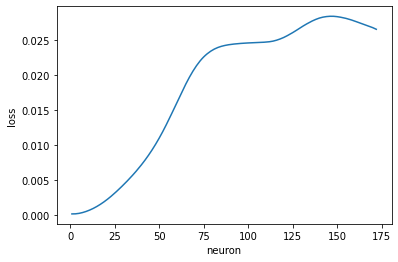

[146, 145, 147]

In [106]:
qual = quality(172, filtered_ts, model["RNN"], 3)
qual

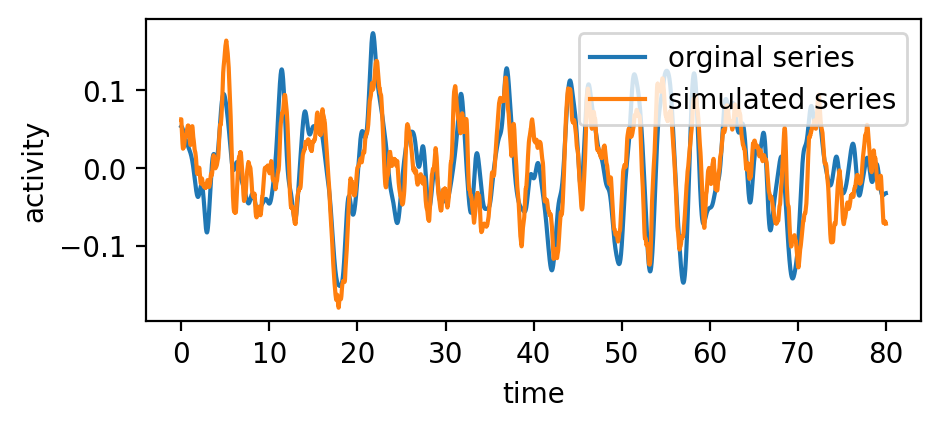

In [107]:
i=22
plt.figure(figsize=(5,2), dpi=200)
plt.plot(model['tData'],filtered_ts[i,:], label = 'orginal series')
plt.plot(model['tRNN'],model['RNN'][i,:], label = 'simulated series')
plt.xlabel('time')
plt.ylabel('activity')
plt.legend(loc='upper right')

---
### **Extra**

### Modèle 4

Dans ce modèle, nous utilisons le même format que le modèle 1, excepté que nous utilisons l'optimiseur <code> LBFGS

In [54]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    """Function that train our RNN to match a specific model

    Args:
        n_neurons (int): Number of neuron
        x (ndarray): Matrix (n_data x n_neuron)
        dt (float): Euler's discretisation
        mu (flaot): Activation threshold
        lr (float, optional): Learning rate. Defaults to 1.
        n_iters (int, optional): Number of iterations (epoch). Defaults to 500.
        g (flaot, optional): Standard deviation of random matrix. Defaults to 1.
        momentum (float, optional): Momentum of SGD [0,1]. Defaults to 0.
        verbose (bool, optional): Update on epochs. Defaults to False.
        loss_graph (bool, optional): Plot loss graph. Defaults to False.

    Returns:
        dict: Parameters of the training
    """
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up

    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W, requires_grad=True)  #Parameter that will be modify

    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    loss = nn.MSELoss()

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=(x.shape[0])**2)

        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred[1] = model(x[0])  #Find x_pred at time (t+1)

        for i in range(x.shape[0] - 2):
            with torch.no_grad():
                x_pred_temp = x_pred[i+1].clone()
            x_pred[i+2] = model(x_pred_temp)

        #Loss
        #l = loss(x, x_pred)

        #Gradient
        #l.backward()

        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
                l = loss(x, x_pred)
            if l.requires_grad:
                l.backward(retain_graph=True)
            return l

        #update weight matrix
        optimizer.step(closure)
        optimizer.zero_grad()

        with torch.no_grad():
            l = loss(x, x_pred)

        if verbose:
            if (epoch+1) % 1 == 0:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

C:\Users\Anthony\AppData\Local\Temp\ipykernel_21404\1389200343.py:1: RuntimeWarning: overflow encountered in exp
  def GenerateData(n_data, time, IC, W, ratio=1, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):


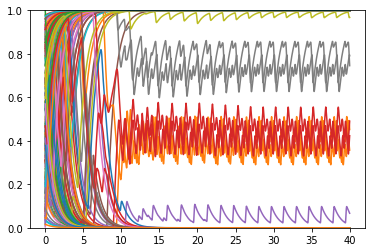

In [55]:
IC = np.random.rand(172)
W = 50*np.random.randn(172, 172)

data = GenerateData(2000, 40, IC=IC, W=W, mu=2)

t = np.linspace(0, 40, 2000)

plt.plot(t, data["Data"].T)
plt.ylim([0,1])
plt.show()

epoch 0/30 loss 0.478946 pVar -35.165
epoch 1/30 loss 0.404308 pVar -18.160
epoch 2/30 loss 0.320201 pVar -17.329
epoch 3/30 loss 0.284193 pVar -32.870
epoch 4/30 loss 0.240226 pVar -31.967
epoch 5/30 loss 0.217523 pVar -40.623
epoch 6/30 loss 0.207701 pVar -38.309
epoch 7/30 loss 0.198315 pVar -37.513
epoch 8/30 loss 0.196671 pVar -38.494
epoch 9/30 loss 0.197704 pVar -38.970
epoch 10/30 loss 0.197704 pVar -38.970
epoch 11/30 loss 0.197704 pVar -38.970
epoch 12/30 loss 0.197704 pVar -38.970
epoch 13/30 loss 0.197704 pVar -38.970
epoch 14/30 loss 0.197704 pVar -38.970
epoch 15/30 loss 0.197704 pVar -38.970
epoch 16/30 loss 0.197704 pVar -38.970
epoch 17/30 loss 0.197704 pVar -38.970
epoch 18/30 loss 0.197704 pVar -38.970
epoch 19/30 loss 0.197704 pVar -38.970
epoch 20/30 loss 0.197704 pVar -38.970
epoch 21/30 loss 0.197704 pVar -38.970
epoch 22/30 loss 0.197704 pVar -38.970
epoch 23/30 loss 0.197704 pVar -38.970
epoch 24/30 loss 0.197704 pVar -38.970
epoch 25/30 loss 0.197704 pVar -38.

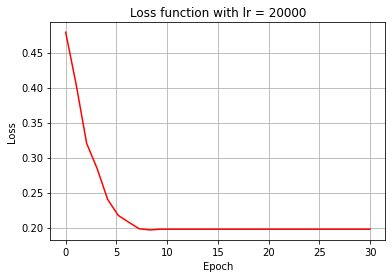

60.42530417442322


In [75]:
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], lr=20000, n_iters=30, g=2, momentum=0.99, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

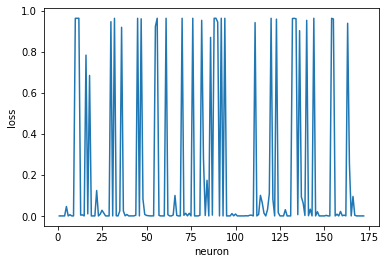

[60, 143, 91]

In [76]:
quality(172, data["Data"].T, pred["x_pred"], 3)

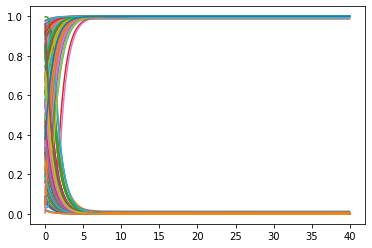

In [71]:
t = np.linspace(0, 40, 2000)

#plt.plot(t, pred["x"])
plt.plot(t, pred["x_pred"])
plt.show()